In [1]:
import pandas as pd, csv, seaborn as sns, matplotlib.pyplot as plt, numpy as np
from io import StringIO
from collections import defaultdict, deque, UserDict, namedtuple
from copy import deepcopy
from pprint import pprint
from itertools import product
from matplotlib.ticker import FuncFormatter
from functools import lru_cache

pd.options.display.float_format = '{:,.4f}'.format
%matplotlib inline

## Read in data

In [168]:
class TDStatement:
    def __init__(self, fp):
        self.fp = fp
        self._setup()
    
    def _setup(self):
        with open(fp) as f:
            s = f.read()

        data = defaultdict(list)
        header = ''
        start = False
        for line in s.split('\n')[1:]:
            if line == '':
                start = True
            else:
                if start:
                    header = line
                    start = False
                else:
                    data[header].append(line)

        self._data = {
            '_'.join(k.strip().lower().split()): v
            for k,v in data.items()
            if k.strip()
        }
    

    def read_entries(self, k):
        c = StringIO('\n'.join(self._data[k]))
        return pd.read_csv(c)
        
    
    @property
    @lru_cache(maxsize=int(2e6))
    def trade_history(self):
        df = self.read_entries('account_trade_history')
        df = df.iloc[:, 1:]
        df.loc[:,'Exec Time'] = pd.to_datetime(df['Exec Time'])
        df = df[~((df.Symbol=='GEO')&(df['Exec Time'].dt.year==2016))]
        df = df.assign(
            close=pd.concat([
                df[df.Spread=='STOCK'].Qty * df[df.Spread=='STOCK']['Net Price'],
                df[df.Spread=='SINGLE'].Qty * 100 * df[df.Spread=='SINGLE']['Net Price'],
                df[df.Spread=='FUTURE'].Qty * 1000 * df[df.Spread=='FUTURE']['Net Price'],
            ])
        )
        return df.sort_values('Exec Time', ascending=True)
    
    
    @property
    @lru_cache(maxsize=int(2e6))
    def trade_effect(self):
        trd_hist = self.trade_history
        return (
            trd_hist
            .groupby([trd_hist['Exec Time'].dt.date,'Pos Effect'])
            .close.sum().unstack(1).fillna(0)
        )
    
    
    @property
    @lru_cache(maxsize=int(2e6))
    def trade_proceed(self):
        trd_hist = self.trade_history
        return -1 * (
            trd_hist
            .groupby([trd_hist['Exec Time'].dt.date, 'Side'])
            .close.sum().unstack(1).fillna(0)
        )
    
    
    @property
    @lru_cache(maxsize=int(2e6))
    def cash_balance(self):
        df = self.read_entries('cash_balance')
        df = df[df.DATE.notnull()]
        df = df.assign(
            timestamp=pd.to_datetime(df.DATE+' '+df.TIME),
            FEES=df.FEES.str.replace(',','').astype(float),
            COMMISSIONS=df.COMMISSIONS.str.replace(',','').astype(float),
            AMOUNT=df.AMOUNT.str.replace(',','').astype(float),
            BALANCE=df.BALANCE.str.replace(',','').astype(float),
        ).drop(['DATE','TIME'], axis=1)

        df.loc[:,'REF #'] = df['REF #'].apply(lambda x: '{:0.0f}'.format(x))
        return df
    
    
    @lru_cache(maxsize=int(2e6))
    def entry_by_type(self, type):
        cash = self.cash_balance
        ts_date = cash.timestamp.dt.date
        type_ = type.upper()
        
        if type_ == 'BAL':
            bal_desc = (
                cash[cash.TYPE==type_]
                .DESCRIPTION.str.split().str[:8].str.join(' ')
            )
            return (
                cash[cash.TYPE==type_]
                .groupby([ts_date, bal_desc])
                .BALANCE.sum().unstack(1)
            )
        elif type == 'TRD':
            return pd.concat([
                cash.groupby(ts_date)['FEES','COMMISSIONS'].sum(),
                -1 * self.trade_effect,
            ], axis=1).fillna(0)
        else:
            return (
                cash[cash.TYPE==type.upper()]
                .groupby([ts_date, 'DESCRIPTION'])
                .AMOUNT.sum().unstack(1)
            )


    @property
    @lru_cache(maxsize=int(2e6))
    def balance_sheet(self):
        cash = self.cash_balance
        ts_date = cash.timestamp.dt.date
        opt_in_date = cash.ix[cash.DESCRIPTION=='Account Opt In', 'timestamp'].iloc[0].date()

        bal_desc = cash[cash.TYPE=='BAL'].DESCRIPTION.str.split().str[:8].str.join(' ')
        bs = pd.concat([
            self.entry_by_type(t)
            for t in ['BAL','JRN','ADJ','DOI','RAD','EFN','TRD']
        ], axis=1).fillna(0)

        start = (
            bs['Cash balance at the start of business day']
            - bs['Account Opt In'].fillna(0)
            - (bs['Courtesy Adjustment'] + bs['Courtesy Credit'])
        )
        bs = pd.DataFrame({
            'start_balance': start,
            'end_balance': (
                start
                + bs.drop(['Cash balance at the start of business day'],axis=1)
                    .fillna(0).sum(1)
            ),
            'jrn': (
                bs['INTRA-ACCOUNT TRANSFER']
                + bs['MARK TO THE MARKET'] + bs['REBATE']
            ),
            'interest': (
                bs['OFF-CYCLE INTEREST~MMDA1']
                + bs['MONEY MARKET INTEREST 0.02 MMDA1']
                + bs['FREE BALANCE INTEREST ADJUSTMENT~NO DESCRIPTION']
            ),
            'efn': (
                bs['CLIENT REQUESTED ELECTRONIC FUNDING DISBURSEMENT (FUNDS NOW)']
                + bs['CLIENT REQUESTED ELECTRONIC FUNDING RECEIPT (FUNDS NOW)']
                + bs['Account Opt In']
            ),
            'trd': bs['TO OPEN'] + bs['TO CLOSE'],
            'fees': bs.FEES,
            'commissions': bs.COMMISSIONS,
        })[[
            'start_balance', 'efn', 'jrn', 'interest',
            'fees', 'commissions', 'trd', 'end_balance'
        ]]
        return bs[opt_in_date:]
    
    
    def outflow(self):
        bs = self.balance_sheet
        adj = self.entry_by_type('ADJ')
        efn = self.entry_by_type('EFN')
        
        return (
            -1 * adj['Account Opt In'].ix[bs.index].fillna(0)
            + -1 * efn['CLIENT REQUESTED ELECTRONIC FUNDING RECEIPT (FUNDS NOW)'].ix[bs.index].fillna(0)
            + self.trade_proceed.BUY.ix[bs.index].fillna(0)
        )
    
    
    def inflow(self):
        bs = self.balance_sheet
        adj = self.entry_by_type('ADJ')
        efn = self.entry_by_type('EFN')
        jrn = self.entry_by_type('JRN')
        doi = self.entry_by_type('DOI')
        rad = self.entry_by_type('RAD')
        return (
            adj[['Courtesy Adjustment', 'Courtesy Credit']].ix[bs.index].fillna(0).sum(1)
            + -1 * efn['CLIENT REQUESTED ELECTRONIC FUNDING DISBURSEMENT (FUNDS NOW)'].ix[bs.index].fillna(0)
            + jrn['REBATE'].ix[bs.index].fillna(0)
            + doi.ix[bs.index].fillna(0).sum(1)
            + rad.ix[bs.index].fillna(0).sum(1)
            + self.trade_proceed.SELL.ix[bs.index].fillna(0)
        )

## Trade History | Holding & PnL

In [169]:
class AccountSummary:
    dirs = ['LONG', 'SHORT']
    types = ['ETF', 'STOCK', 'PUT', 'CALL', 'FUTURE']
    
    def __init__(self, trade_history, balance_sheet):
        self.trd_hist = trade_history.sort_values('Exec Time', ascending=True)
        self.bs = balance_sheet
        self.types = trade_history.Type.unique().tolist()
    
    
    def iter_trade_date(self):
        gp = self.trd_hist.groupby([self.trd_hist['Exec Time'].dt.date])
        for dt, chunk in gp:
            yield dt, chunk
            
            
    def iter_trade(self, trade_chunk):
        for _, row in trade_chunk.iterrows():
            yield Trade(
                symbol=row['Symbol'],
                type=row['Type'],
                effect=row['Pos Effect'],
                side=row['Side'],
                qty=row['Qty'],
                price=row['Net Price'],
            )
    
    
    def holding(self):
        holding = []
        cur_holding = {t: {d: {} for d in self.dirs} for t in self.types}
        
        for dt, chunk in self.iter_trade_date():
            cur_holding['timestamp'] = dt
            for trade in self.iter_trade(chunk):
                S, Q = trade.S, trade.Q
                T, D = trade.T, trade.D
                
                if S in cur_holding[T][D]:
                    cur_holding[T][D][S] += Q
                else:
                    cur_holding[T][D][S] = Q

            for t, d in list(product(self.types, self.dirs)):
                cur_holding[t][d] = {k:v for k,v in cur_holding[t][d].items() if v!=0}

            holding.append(deepcopy(cur_holding))

        return (
            pd.DataFrame(holding)
              .set_index('timestamp')
              .ix[self.bs.index, :]
              .fillna(method='ffill')
        )
    
    
    def pnl(self):
        pnl = []
        cur_pnl = {'pnl': 0}
        fifo = FIFO()

        for dt, chunk in self.iter_trade_date():
            cur_pnl['timestamp'] = dt
            for trade in self.iter_trade(chunk):
                cur_pnl['pnl'] += fifo.include(trade)

            pnl.append(deepcopy(cur_pnl))

        return (
            pd.DataFrame(pnl)
              .set_index('timestamp')
              .ix[self.bs.index, :]
              .fillna(method='ffill').fillna(0)
        )
    
    
    def summary(self):
        df = (
            self.bs
            .merge(self.holding(), how='left', left_index=True, right_index=True)
            .merge(self.pnl(), how='left', left_index=True, right_index=True)
        ).rename(
            columns={'pnl': 'realized'}
        )

        df.loc[:, 'net_realized'] = df.realized + (df.fees + df.commissions).cumsum()
        df.loc[:, 'cash_value'] = (df.efn + df.jrn + df.interest).cumsum()
        df.loc[:, 'realized_account_value'] = df.net_realized + df.cash_value
        return df

    
class AccountDashboard:
    def account_value(self, account_summary):
        df = account_summary
        with sns.axes_style('white'):
            ax = df[['realized_account_value','cash_value']].plot(figsize=(12,5))

        sns.despine(top=True, right=True)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x,p: '{:0.0f}K'.format(x/1000)))
        ax.legend(labels=['Realized\nAccount Value', 'Cash Value'], bbox_to_anchor=(1.2,0.5))
        return ax


class Trade:
    __slot__ = ['symbol', 'type', 'effect', 'side', 'qty', 'price']
    
    def __init__(self, symbol, type, effect, side, qty, price):
        self.symbol = symbol
        self.type = type
        self.effect = effect
        self.side = side
        self.qty = qty
        self.price = price
    
    
    @property
    def direction(self):
        effect, side = self.effect, self.side
        
        if effect == 'TO OPEN':
            if side == 'BUY':
                direction = 'LONG'
            else:
                direction = 'SHORT'
        elif effect == 'TO CLOSE':
            if side == 'BUY':
                direction = 'SHORT'
            else:
                direction = 'LONG'
        return direction


    @property
    def multipler(self):
        T = self.T
        if T in ['PUT', 'CALL']:
            return 100
        elif T == 'FUTURE':
            return 1000
        return 1

    
    @property
    def D(self): return self.direction
        
    @property
    def S(self): return self.symbol
    
    @property
    def Q(self): return self.qty
    
    @property
    def P(self): return self.price
    
    @property
    def E(self): return self.effect
    
    @property
    def T(self): return self.type
    
    @property
    def M(self): return self.multipler


class FIFO(UserDict):
    def __init__(self):
        self.data = {
            t: {d: {} for d in AccountSummary.dirs}
            for t in AccountSummary.types
        }
    
    def include(self, trade):
        pnl = 0
        S, D, T, E = trade.S, trade.D, trade.T, trade.E
        new_jrn = {'qty': trade.Q, 'cost': trade.P}
        
        if S not in self[T][D]:
            self[T][D][S] = deque([new_jrn])
        
        else:
            if E == 'TO OPEN':
                self.on_open(trade, new_jrn)
            elif E == 'TO CLOSE':
                pnl += self.on_close(trade, new_jrn)
        return pnl
    
    
    def on_open(self, trade, new_jrn):
        T, D, S = trade.T, trade.D, trade.S
        self[T][D][S].append(new_jrn)
    
    
    def on_close(self, trade, new_jrn):
        pnl = 0
        S, Q, P = trade.S, trade.Q, trade.P
        T, D, M = trade.T, trade.D, trade.M
        filling_qty = abs(Q)
        
        while filling_qty > 0:
            last = self[T][D][S].popleft()
            filled = min(filling_qty, abs(last['qty']))
            filling_qty -= filled

            if D == 'LONG':  # closing a LONG position
                pnl += last['qty'] * (P - last['cost']) * M
                last['qty'] -= filled
            elif D == 'SHORT':  # closing a SHORT position
                pnl += last['qty'] * (P - last['cost']) * M
                last['qty'] += filled

            if abs(last['qty']) > 0:
                self[T][D][S].appendleft(last)
        return pnl

## P&L

In [170]:
fp = r'/home/user/workspace/data/raw/2016-12-27-AccountStatement.csv'
st = TDStatement(fp)
summarier = AccountSummary(st.trade_history, st.balance_sheet)
dashboard = AccountDashboard()

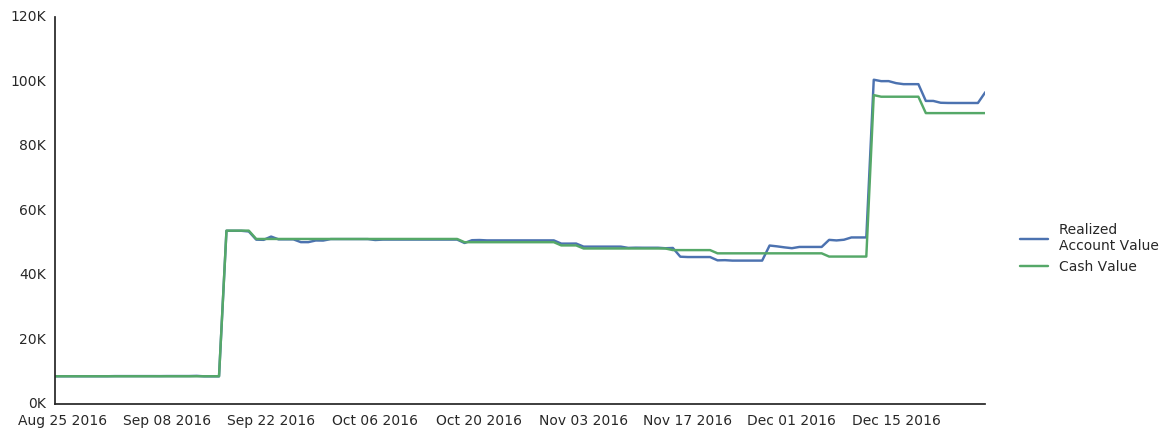

In [171]:
summary = summarier.summary()
ax = dashboard.account_value(summary)

In [80]:
summary.to_excel('/home/user/workspace/data/excel/jacky td_2016-12-27.xlsx')

In [81]:
ax.figure.savefig('/home/user/workspace/graph/jack td_2016-12-27.pdf', dpi=600, transparent=True, bbox_inches='tight', pad_inches=0.3)